In [1]:
import sys
import numpy as np
import pandas as pd

%matplotlib inline

import matplotlib
import seaborn as sns
from matplotlib import pyplot as plt

# plt.style.use('whitegrid')
sns.set_style('whitegrid')

matplotlib.rcParams.update({'figure.figsize': (10, 6)})
matplotlib.rcParams.update({'font.size': 16})
matplotlib.rcParams.update({'axes.labelsize': 20})
matplotlib.rcParams.update({'xtick.labelsize': 12})
matplotlib.rcParams.update({'ytick.labelsize': 12})
matplotlib.rcParams.update({'font.family': 'Helvetica, Arial, sans-serif'})

%config InlineBackend.figure_format = 'retina'

In [2]:
# https://www.kaggle.com/shivam2503/diamonds/data
# Pristine copy of dataset (No modification)
diamonds = pd.read_csv('data/diamonds.csv')

from copy import deepcopy
# Features
data = deepcopy(diamonds[['carat', 'x', 'y', 'z', 'depth', 'table', 'price',
                          'clarity', 'color']])
# Lables
target = deepcopy(diamonds['cut']).astype('category')

# Force all numerical data to zero mean one std
for col in ['carat','x','y','z','depth','table','price']:
    data[col] = (data[col] - data[col].mean()) / data[col].std()

# Define color and clarity as categorical types
for col in ['color', 'clarity']:
    data[col] = data[col].astype('category');

data.describe()

,carat,x,y,z,depth,table,price
count,5.394000e+04,5.394000e+04,5.394000e+04,5.394000e+04,5.394000e+04,5.394000e+04,5.394000e+04
mean,2.149807e-16,2.508108e-16,-2.107654e-17,-2.023348e-16,-4.002434e-15,1.175017e-16,-1.095980e-16
std,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
min,-1.261446e+00,-5.109073e+00,-5.020884e+00,-5.014510e+00,-1.308748e+01,-6.470013e+00,-9.040868e-01
25%,-8.395154e-01,-9.103164e-01,-8.882717e-01,-8.909378e-01,-5.231005e-01,-6.521325e-01,-7.476738e-01
50%,-2.066190e-01,-2.777527e-02,-2.147379e-02,-1.237607e-02,3.531645e-02,-2.046032e-01,-3.839636e-01
75%,5.106635e-01,7.210475e-01,7.052356e-01,7.103118e-01,5.239313e-01,6.904554e-01,3.487834e-01
max,8.885992e+00,4.465161e+00,4.654922e+01,4.004720e+01,1.204128e+01,1.680151e+01,3.732404e+00


In [3]:
from sklearn.model_selection import train_test_split
# Split test and train data
data_train, data_test, target_train, target_test = train_test_split(data, target, test_size=0.2)

from sklearn.preprocessing import LabelEncoder

##### KERAS #####
from keras import optimizers
from keras.models import Sequential
from keras.layers import Dense, Activation, Input
from keras.layers import Embedding, Flatten, Merge, concatenate
from keras.models import Model

Using TensorFlow backend.


In [49]:
from functools import reduce

class WideDeepNetwork():
    def __init__(
        self, epochs=5, batch_size=35, activation='relu', final_activation='sigmoid', optimizer='adagrad', 
        loss='mean_squared_error', metrics=['accuracy'], deep_input_size=5, 
        deep_layer_sizes=[50,10], numeric_features=None, categorical_features=None,
        cross_categories=None,
    ):
        self.epochs = epochs
        self.batch_size = batch_size
        
        self.activation = activation
        self.final_activation = final_activation
        self.optimizer = optimizer
        self.loss = loss
        self.metrics = metrics
        
        self.deep_input_size = deep_input_size
        self.deep_layer_sizes = deep_layer_sizes
        self.numeric_features = numeric_features
        self.categorical_features = categorical_features
        self.cross_categories = cross_categories
        
    def _make_wide_network(self):
        ## we need to create separate sequential models for each embedding
        embed_branches = []
        X_ints_train = []
        all_inputs = []
        all_branch_outputs = []
        
        if not all(isinstance(element, list) for element in self.cross_categories):
            raise ValueError('cross_categories should be type [[]]')

        # For all sets of columns to be crossed
        for cols in self.cross_categories:
            # Gets number of 1-hot encoded crossed classes given categories and values
            N = 1
            for col in cols:
                N *= len(self.categorical_features[col])
            N += 1

            ## create embedding branch from the number of categories
            # Create inputs for each of the crossed columns
            inputs = Input(shape=(1,),dtype='int32', name = '_'.join(cols))
            # Adds the Inputs to a list
            all_inputs.append(inputs)
            # Creates an Embedding with input number of categories and output the sqrt(#categories). 
            #  input_length is max matrix size of input
            # Passes inputs into embedding
            x = Embedding(input_dim=N, output_dim=int(np.sqrt(N)), input_length=1)(inputs)
            # Flatten the dimension of the Embedding
            x = Flatten()(x)
            # Add the Flattened Embedding to the list
            all_branch_outputs.append(x)

        # Merge branches into one branch
        if(len(all_branch_outputs) == 1):
            wide_branch = all_branch_outputs[0]
        else:
            wide_branch = concatinate(all_branch_outputs)
            
        # Return input layer and wide branch layer
        return all_inputs, wide_branch
    
    def _make_deep_network(self):
        if not all(isinstance(element, list) for _, element in self.categorical_features.items()):
            raise ValueError('Categorical features must be a dictonary of lists')
        
        all_inputs = []  
        all_branch_outputs = []
        
        for key, l in self.categorical_features.items():
            # Get highest int classification of category feature
            N = len(l)

            # Input defines the tensor shape
            ## create embedding branch from the number of categories
            inputs = Input(shape=(1,),dtype='int32', name=key)
            # Create a list of all the Inputs
            all_inputs.append(inputs)

            # Create embeding layer of N with inputs
            x = Embedding(input_dim=N, output_dim=int(np.sqrt(N)), input_length=1)(inputs)

            x = Flatten()(x)
            all_branch_outputs.append(x)

        ## also get a dense branch of the numeric features
        if len(self.numeric_features) < 1:
            raise ValueError('Numeric Features must not be empty')
        
        # Add numerical input layer
        all_inputs.append(Input(shape=(len(self.numeric_features),),sparse=False, name='numeric_data'))

        # Gets a dense encoding of all the numerical data
        x = Dense(units=self.deep_input_size, activation=self.activation)(all_inputs[-1])
        all_branch_outputs.append( x )

        # merge the branches together
        deep_branch = concatenate(all_branch_outputs)
        
        # Define the deep layer 
        for units in self.deep_layer_sizes:
            deep_branch = Dense(units=units,activation=self.activation)(deep_branch)
            
        # Return input layer and deep branch
        return all_inputs, deep_branch
        
    def make_model(self):
        # Get all input layers and the network branches
        wide_input, wide_branch = self._make_wide_network()
        deep_input, deep_branch = self._make_deep_network()
        # combine inputs
        all_inputs = wide_input + deep_input
        
        # Define the final output branch to dense 5 nuron output
        final_branch = concatenate([wide_branch, deep_branch])
        final_branch = Dense(units=5,activation=self.final_activation)(final_branch)
        
        # Define model with input and outputs
        self.model = Model(inputs=all_inputs, outputs=final_branch)
        
        # Compile to model to allow fiting
        self.model.compile(optimizer=self.optimizer,
                           loss=self.loss,
                           metrics=self.metrics)
        
    
    def fit(self, X, y, print_progress=False):
        # Define input format
        X_train = []
        # Get crossed categorical values
        for cols in self.cross_categories:
            X_crossed_train = X[cols].apply(lambda x: '_'.join(x), axis=1).astype('category')
            X_train.append(X_crossed_train.cat.codes)
        # Get single categorical values
        for col in list(self.categorical_features.keys()):
            X_train.append(X[col].cat.codes)
        # Get numerical values
        X_train.append(np.asarray(X[self.numeric_features]))
        
        # Encode the categorical data to 1 hot encoding
        y_one_hot = np.asarray(pd.get_dummies(target_train))
        
        # Model requires X_train in format of [crossed_categorical(ints), Cat_1, Cat_2, Cat_n, [numerical_data]]
        self.model.fit(X_train, y_one_hot, 
                       epochs=self.epochs, batch_size=self.batch_size, 
                       verbose=print_progress)
    
    def predict(self, X):
        # Define input format
        X_test = []
        # Get crossed categorical values
        for cols in self.cross_categories:
            X_crossed_test = X[cols].apply(lambda x: '_'.join(x), axis=1).astype('category')
            X_test.append(X_crossed_test.cat.codes)
        # Get single categorical values
        for col in list(self.categorical_features.keys()):
            X_test.append(X[col].cat.codes)
        # Get numerical values
        X_test.append(np.asarray(X[self.numeric_features]))
        
        # Model requires X_test in format of [crossed_categorical(ints), Cat_1, Cat_2, Cat_n, [numerical_data]]
        return self.model.predict(X_test)
        
    # [CITE] http://algoadventures.com/sklearn-from-the-source-code-up-basics/
    # ClassifierMixin implementation
    def score(self, X, y, sample_weight=None):
        from sklearn.metrics import accuracy_score
        return accuracy_score(y, self.predict(X), sample_weight=sample_weight)
    # end implementation

In [76]:
# Define features
numeric_featues = ['carat', 'x', 'y', 'z', 'depth', 'table', 'price']
cross_categories = [['clarity','color']]
categorical_features = {'clarity': data['clarity'].value_counts().keys().tolist(), 
                        'color': data['color'].value_counts().keys().tolist()}


wdNet = WideDeepNetwork(epochs = 10,
                        batch_size = 32,
                        optimizer = 'Nadam',
                        loss = 'categorical_crossentropy',
                        metrics = ['categorical_accuracy'],
                        deep_input_size = 25,
                        deep_layer_sizes = [35,80,60,25],
                        numeric_features = numeric_featues, 
                        categorical_features = categorical_features, 
                        cross_categories = cross_categories)

wdNet.make_model()
wdNet.fit(data_train, target_train, print_progress=1)

Epoch 1/10
43152/43152 [==============================] - 7s - loss: 0.8046 - categorical_accuracy: 0.6913     
Epoch 2/10
43152/43152 [==============================] - 6s - loss: 0.7355 - categorical_accuracy: 0.7154     
Epoch 3/10
43152/43152 [==============================] - 6s - loss: 0.6907 - categorical_accuracy: 0.7316     
Epoch 4/10
43152/43152 [==============================] - 6s - loss: 0.5964 - categorical_accuracy: 0.7655     
Epoch 5/10
43152/43152 [==============================] - 6s - loss: 0.5638 - categorical_accuracy: 0.7753     
Epoch 6/10
43152/43152 [==============================] - 6s - loss: 0.5483 - categorical_accuracy: 0.7833     
Epoch 7/10
43152/43152 [==============================] - 6s - loss: 0.5383 - categorical_accuracy: 0.7868     
Epoch 8/10
43152/43152 [==============================] - 6s - loss: 0.5297 - categorical_accuracy: 0.7882     
Epoch 9/10
43152/43152 [==============================] - 6s - loss: 0.5250 - categorical_accuracy: 0.79

In [77]:
y_hat = wdNet.predict(data_test)

[[ 267   29    3    9   12]
 [  34  579   12   11  320]
 [   3    5 3985  132  159]
 [   0   12  333 2171  313]
 [   3  101  556  246 1493]]


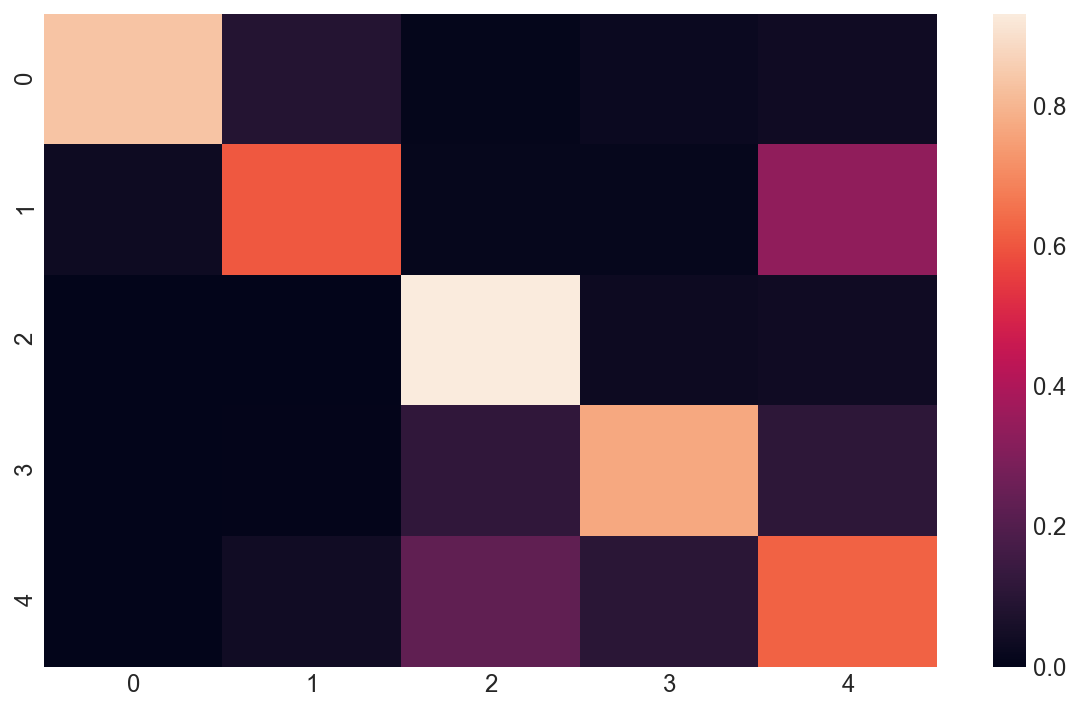

In [78]:
from sklearn.metrics import confusion_matrix
target_test_one_hot = pd.get_dummies(target_test)
cnf = confusion_matrix(
    np.asarray(target_test_one_hot).argmax(1),
    y_hat.argmax(1)
)
print(cnf)
cnf_norm = cnf.astype('float') / cnf.sum(axis=1)[:, np.newaxis]
sns.heatmap(cnf_norm)

In [81]:
from sklearn.metrics import roc_auc_score


# gets the column of the maximum for each row
# then converts it to binary (manual one-hot encoding)
y_hat_one_hot = np.zeros(y_hat.shape)
y_hat_one_hot[np.arange(y_hat.shape[0]), y_hat.argmax(1)] = 1

# ROC Area under Curve score
roc_auc_score(
    np.asarray(target_test_one_hot),
    y_hat_one_hot
)


0.84563707608594174

In [ ]:
data['clarity'].value_counts().keys().tolist()